# Autor
Danilo César Tertuliano Melo - 221031149

Github: DaniloCTM

------
# Objetivo

O objetivo deste artigo é treinar um modelo para identificar a diferença entre helicopteros e aviões. Além disso, o modelo foi publicado no hugginFace.

------
# Passo 1 - Configurando o Ambiente

Começamos instalando as bibliotecas necessárias para o projeto

In [ ]:
!pip install duckduckgo_search

In [5]:
from fastai.vision.all import *
from fastdownload import download_url


from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Em seguida realizamos o download das imagens usando a API do Duckduckgo

In [6]:
searches = 'helicopter','airplane'
path = Path('airplane_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'helicopter photo'
Searching for 'helicopter sun photo'
Searching for 'helicopter shade photo'
Searching for 'airplane photo'
Searching for 'airplane sun photo'
Searching for 'airplane shade photo'


-----

# Passo 2 - Organizando os Dados
Agora com os dados já baixados preparamos eles e verificamos se existe algum problema nas imagens

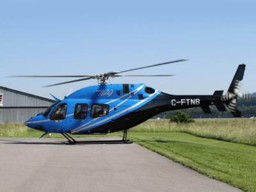

In [13]:
path = Path('/kaggle/working/airplane_or_not')
dest = f'{path}/helicopter/7cd1b648-f9a9-4578-bf38-f3c1d5810b2f.jpg'
im = Image.open(dest)
im.to_thumb(256,256)

In [14]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

-----
# Passo 3 - Treinando o Modelo

Primeiro, criamos os conjuntos de dados por meio da função DataBlock(), onde definimos:

* O formato de entrada e saída dos dados
* O tamanho do conjunto de validação e treinamento
* O tamanho das imagens passadas para o modelo

Em seguida, exibimos uma batch com alguns dos dados.

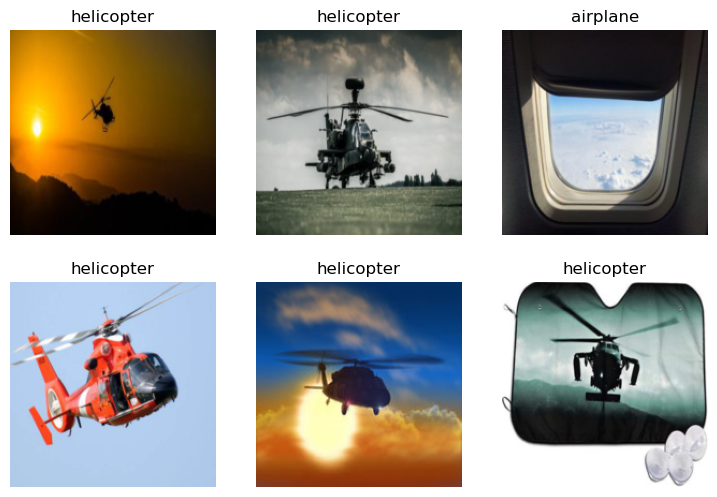

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Agora realizamos de fato o treinamento usando as funções da biblioteca fastai. Para isso, criamos um modelo de rede neural convolucional usando a função cnn_leaner() e, em seguida, ajustamos os pesos da rede por meio da função fine_tune().

In [15]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.480555,0.981400,0.333333,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.633614,0.467806,0.222222,00:10
1,0.507556,0.394904,0.111111,00:10
2,0.383047,0.402391,0.111111,00:10
3,0.312534,0.398552,0.111111,00:10
4,0.255668,0.393791,0.111111,00:10


Após o modelo ser treinado é possível verificar a matrix de confução do modelo e por meio dela entender onde o modelo encontrou mais dificuldade

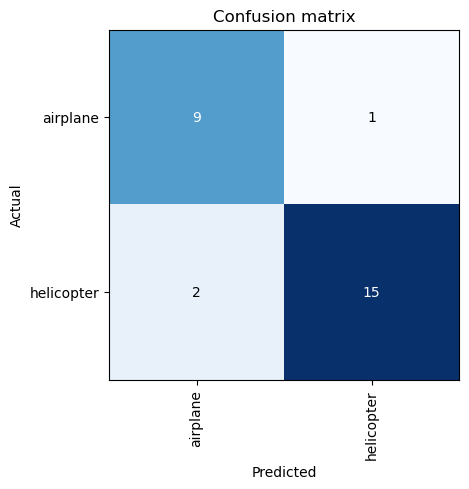

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

-------
# Passo 4 - Testando o Modelo

Nessa etapa verificamos se o modelo está funcionando por meio de um teste no kaggle. Neste teste ele recebe uma imagem e retorna a classificação dela e a probabilidade de ser um avião.

This is a: airplane.
Probability it's a airplane: 1.0000


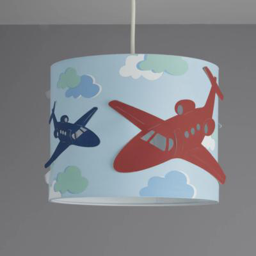

In [28]:
dest = '/kaggle/working/airplane_or_not/airplane/0449ea76-14eb-4808-acaa-640c5977095c.jpg'
is_airplane,_,probs = learn.predict(PILImage.create(dest))
print(f"This is a: {is_airplane}.")
print(f"Probability it's a airplane: {probs[0]:.4f}")
im = Image.open(dest)
im.to_thumb(256,256)

----
# Passo 5 - Fazendo Deploy do Modelo

Com o modelo treinado e testado localmente exportamos o modelo para usar no hugging Face

In [ ]:
learn.export('model.pkl')

Com tudo configurado no Hugging Face o modelo fica disponível no seguinte link:

https://huggingface.co/spaces/DaniloTertu/lesson-2

# Conclusão

Durante essa lição foi possível verificar que após o modelo ser treinado ele pode ser exportado para funcionar em outros ambientes sem precisar passar pela etapa de treinamento novamente. Além disso, foi possível revisar os conceitos da primeira lição.